# Контекст

- датасет kinopoisk.ru (отзывы о фильмах)
- бинарная классификация отзывов
- 0 - негативные (train 14275)
- 1 - позитивные (train 62739)
- model = 'distilbert-base-uncased'
- токенизатор сменен на русский язык

In [1]:
# база
import pandas as pd
import warnings
import numpy as np
import json
import time

# визуализация
import seaborn as sns
import matplotlib.pyplot as plt



# pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


warnings.filterwarnings("ignore")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('CUDA ?: ', torch.cuda.is_available())

CUDA ?:  True


# Чтение данных

In [2]:
%%script False

data = pd.read_csv('kinopoisk_binary_sentiment_analysis.csv')
data.head()

Couldn't find program: 'False'


In [3]:
%%script False

data['label'].value_counts()

Couldn't find program: 'False'


# train-val-test split

In [4]:
%%script False

from sklearn.model_selection import train_test_split

train, test = train_test_split(
    data,
    test_size = 0.1,
    stratify = data['label'],
    shuffle = True,
    random_state = 42
)

train, val = train_test_split(
    train,
    test_size = 0.2,
    shuffle = True,
    stratify = train['label'],
    random_state = 42
)

Couldn't find program: 'False'


In [5]:
%%script False

print(len(train), len(val), len(test))

Couldn't find program: 'False'


# Скачивание DistillBert и установка RU токенизатора

In [6]:
from transformers import (DistilBertTokenizerFast, DistilBertForSequenceClassification, AutoTokenizer)

model_path= 'distilbert-base-uncased'
tokenizer = DistilBertTokenizerFast.from_pretrained(model_path)
model = DistilBertForSequenceClassification.from_pretrained(
                                                            model_path,
                                                            id2label={0: "NEG", 1: "POS"},
                                                            label2id={"NEG": 0, "POS": 1}
                                                            )

russian_tokenizer = AutoTokenizer.from_pretrained("DmitryPogrebnoy/distilbert-base-russian-cased")
model.tokenizer = russian_tokenizer

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classi

In [7]:
russian_tokenizer.vocab_size

13982

# Токенизация dataset

In [8]:
%%script False

tokenize_data_train = russian_tokenizer(
    train['text'].to_list(),
    padding = True,
    truncation = True,
    return_attention_mask=True
)

tokenize_data_val = russian_tokenizer(
    val['text'].to_list(),
    padding = True,
    truncation = True,
    return_attention_mask=True
)

tokenize_data_test = russian_tokenizer(
    test['text'].to_list(),
    padding = True,
    truncation = True,
    return_attention_mask=True
)

train['input_ids'], train['attention_mask'] = tokenize_data_train['input_ids'], tokenize_data_train['attention_mask']
val['input_ids'], val['attention_mask'] = tokenize_data_val['input_ids'], tokenize_data_val['attention_mask']
test['input_ids'], test['attention_mask'] = tokenize_data_test['input_ids'], tokenize_data_test['attention_mask']

Couldn't find program: 'False'


In [9]:
%%script False

train.to_csv('train.csv', index = False)
val.to_csv('val.csv', index = False)
test.to_csv('test.csv', index = False)

Couldn't find program: 'False'


In [10]:
%%script False


train = pd.read_csv('train.csv')
val = pd.read_csv('val.csv')
# test = pd.read_csv('test.csv')

def object_to_list(stroka):
    query = stroka.strip('[]')
    return list(map(int, query.split(', ')))


train['attention_mask'] = train['attention_mask'].map(object_to_list)
val['attention_mask'] = val['attention_mask'].map(object_to_list)
train['input_ids'] = train['input_ids'].map(object_to_list)
val['input_ids'] = val['input_ids'].map(object_to_list)

Couldn't find program: 'False'


In [11]:
%%script False

train.head()

Couldn't find program: 'False'


In [12]:
'''training_args = TrainingArguments(

    output_dir = 'training/model_points', # сохранение контрольных точек модели
    do_train = True, # мониторинг производительности
    do_eval = True,
    num_train_epochs = 3,
    per_device_train_batch_size = 32,
    per_gpu_eval_batch_size = 64,
    warmup_steps = 100, # оптмизация скорости обучения
    weight_decay = 0.01, # регуляризация весов модели
    logging_strategy = 'steps', # аналог verbose с сохранением логов (также есть 'epoch')
    logging_dir = 'training/logs',
    save_steps = 200,
    logging_steps = 100,
    evaluation_strategy = 'steps',
    fp16 = True, # Указывает на использование смешанной точности и использует как 16-, так и 32-битные типы с плавающей запятой, чтобы 
                 # обучение проходило быстрее и занимало меньше памяти (Можно fp16 = cuda.is_available())
    load_best_model_at_end = True
)'''

"training_args = TrainingArguments(\n\n    output_dir = 'training/model_points', # сохранение контрольных точек модели\n    do_train = True, # мониторинг производительности\n    do_eval = True,\n    num_train_epochs = 3,\n    per_device_train_batch_size = 32,\n    per_gpu_eval_batch_size = 64,\n    warmup_steps = 100, # оптмизация скорости обучения\n    weight_decay = 0.01, # регуляризация весов модели\n    logging_strategy = 'steps', # аналог verbose с сохранением логов (также есть 'epoch')\n    logging_dir = 'training/logs',\n    save_steps = 200,\n    logging_steps = 100,\n    evaluation_strategy = 'steps',\n    fp16 = True, # Указывает на использование смешанной точности и использует как 16-, так и 32-битные типы с плавающей запятой, чтобы \n                 # обучение проходило быстрее и занимало меньше памяти (Можно fp16 = cuda.is_available())\n    load_best_model_at_end = True\n)"

# Dataset

In [2]:
def object_to_list(stroka):
    query = stroka.strip('[]')
    return list(map(int, query.split(', ')))

In [3]:
class Kinopoisk_Dataset(Dataset):

    def __init__(self, mode):
        self.data = pd.read_csv(f'{mode}.csv')
        self.data = self.data.sample(frac = 1, random_state = 42)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        row = self.data.iloc[index]
        row['input_ids'] = object_to_list(row['input_ids'])
        row['attention_mask'] = object_to_list(row['attention_mask'])
                
        return {
            'input_ids': torch.tensor(row['input_ids']),
            'attention_mask': torch.tensor(row['attention_mask']),
            'labels': torch.tensor(row['label'])
        }

# Trainer

In [15]:
'''trainer = Trainer(

    model = model,
    args = training_args,
    train_dataset = Kinopoisk_Dataset(train.iloc[:10000, :]),
    eval_dataset = Kinopoisk_Dataset(val.iloc[:10000, :]),
    compute_metrics = compute_metrics   
)


results = trainer.train()'''

'trainer = Trainer(\n\n    model = model,\n    args = training_args,\n    train_dataset = Kinopoisk_Dataset(train.iloc[:10000, :]),\n    eval_dataset = Kinopoisk_Dataset(val.iloc[:10000, :]),\n    compute_metrics = compute_metrics   \n)\n\n\nresults = trainer.train()'

# Проверка модели + настройка metric

In [16]:
# train = pd.read_csv('train.csv')
'''val = pd.read_csv('val.csv')
# test = pd.read_csv('test.csv')'''

'''def object_to_list(stroka):
    query = stroka.strip('[]')
    return list(map(int, query.split(', ')))


train['attention_mask'] = train['attention_mask'].map(object_to_list)
# val['attention_mask'] = val['attention_mask'].map(object_to_list)
train['input_ids'] = train['input_ids'].map(object_to_list)
# val['input_ids'] = val['input_ids'].map(object_to_list)'''

"def object_to_list(stroka):\n    query = stroka.strip('[]')\n    return list(map(int, query.split(', ')))\n\n\ntrain['attention_mask'] = train['attention_mask'].map(object_to_list)\n# val['attention_mask'] = val['attention_mask'].map(object_to_list)\ntrain['input_ids'] = train['input_ids'].map(object_to_list)\n# val['input_ids'] = val['input_ids'].map(object_to_list)"

# Pytorch обучение

## Доп. функции (L1_L2 reg, batch metric)

In [4]:
def loss_with_l1_or_l2_regulizer(
        
        model,
        type, # Здесь могут быть 3 вида : 'l1', 'l2', 'l1_l2' 
        l_lambda, # 0.001
        loss_by_fn):
    
    if type == 'l2':
        l_norm = sum(p.pow(2.0).sum() for p in model.parameters())

    if type == 'l1':
        l_norm = sum(p.abs().sum() for p in model.parameters())

    if type == 'l1_l2':
        l_norm = sum((p.abs() + p.pow(2.0)).sum() for p in model.parameters())
    
    loss_plus_reg = loss_by_fn + l_lambda * l_norm
    return loss_plus_reg



def create_folder(name):
    import os
    os.mkdir(name)


'''
def batch_metric(output, y_true):
    output = torch.argmax(output, dim = 1)
    output = output.detach().cpu().numpy()
    y_true = y_true.detach().cpu().numpy()
    f1_score_macro = f1_score(
        y_true = y_true,
        y_pred = output,
        average = 'macro'
    )
    return f1_score_macro
'''



from sklearn.metrics import (accuracy_score, precision_recall_fscore_support)

def compute_metrics(output, y_true):

    y_true = y_true.detach().cpu().numpy()
    y_pred = torch.argmax(output, dim = 1).detach().cpu().numpy()
    Precision, Recall, f1, _ = precision_recall_fscore_support(
        y_true,
        y_pred,
        average = 'macro'
    )
    acc = accuracy_score(y_true, y_pred)
    
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': Precision,
        'Recall': Recall
    }

## Training loop

In [5]:
def training_loop(
        # папка сохранения
        name_model_folder,


        # основные настройки
        epoches,
        model,
        optimizer,

        loss_fn,
        train_dataloader,
        val_dataloader,

        # regulizer
        regulizer_append,
        reg_type,

        # verbose
        verbose_epoch
        ):
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    create_folder(name_model_folder)
    
    '''loss_train_list = []
    loss_val_list = []'''
    batch_data = {
           'loss_train': [],
           'loss_val': [],
           'train_accuracy' : [],
           'train_f1': [],
           'train_precision': [],
           'train_recall': [],
           'val_accuracy' : [],
           'val_f1': [],
           'val_precision': [],
           'val_recall': []
    }

    '''epoch_data = {
           'loss_train': [],
           'loss_val': [],
           'train_accuracy' : [],
           'train_f1': [],
           'train_precision': [],
           'train_recall': [],
           'val_accuracy' : [],
           'val_f1': [],
           'val_precision': [],
           'val_recall': []
    }'''
    best_loss = float('inf')
    model = model.to(device)
    step = 1

    for epoch in range(1, epoches+1):
            
            
            loss_train_summarize = 0.0
            loss_val_summarize = 0.0
            
            start_time = time.time()

            for batch in train_dataloader:
                
                model.train()
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(input_ids, attention_mask)[0]

                # Тренировочный потери
                loss = loss_fn(outputs, labels)
                
                if regulizer_append:
                        loss = loss_with_l1_or_l2_regulizer(
                                model = model,
                                type = reg_type,
                                l_lambda = 0.001,
                                loss_by_fn = loss
                                )
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                loss_train_summarize += loss.item()

                batch_metrics_slovar_train = compute_metrics(outputs, labels)

                batch_data['loss_train'].append(loss.item())
                batch_data['train_accuracy'].append(batch_metrics_slovar_train['Accuracy'])
                batch_data['train_f1'].append(batch_metrics_slovar_train['F1'])
                batch_data['train_precision'].append(batch_metrics_slovar_train['Precision'])
                batch_data['train_recall'].append(batch_metrics_slovar_train['Recall'])

                if np.min(loss.item()) < best_loss:
                        best_loss = loss.item()
                        torch.save(model.state_dict(), f'{name_model_folder}/model_weights_{step}_step.pth')

                step += 1
            #####################################################
            mean_epoch_loss_train = loss_train_summarize / len(train_dataloader)
            # Проверочный этап
            model.eval()
            with torch.no_grad():
                for batch in val_dataloader:
                        input_ids = batch['input_ids'].to(device)
                        attention_mask = batch['attention_mask'].to(device)
                        labels = batch['labels'].to(device)
                        outputs = model(input_ids, attention_mask)[0]
                        loss_on_val = loss_fn(outputs, labels)

                        loss_val_summarize += loss_on_val.item()

                        batch_metrics_slovar_val = compute_metrics(outputs, labels)

                        batch_data['loss_val'].append(loss_on_val.item())
                        batch_data['val_accuracy'].append(batch_metrics_slovar_val['Accuracy'])
                        batch_data['val_f1'].append(batch_metrics_slovar_val['F1'])
                        batch_data['val_precision'].append(batch_metrics_slovar_val['Precision'])
                        batch_data['val_recall'].append(batch_metrics_slovar_val['Recall'])
                
                mean_epoch_val_loss = loss_val_summarize / len(val_dataloader)
                '''# Сохранение состояний модели
                if np.min(batch_data['loss_val']) < best_loss:
                        best_loss = np.min(batch_data['loss_val'])
                        torch.save(model.state_dict(), f'{name_model_folder}/model_weights_{epoch}_epoch.pth')'''
            ##############################################################
            end_time = time.time()
            epoch_time = end_time - start_time
            расчетное_время_выполнения_цикла = (epoch_time*epoches) / 60
            ############ VERBOSE #########################################
            if epoch == 1:
                   print('Расчетное время выполнения всего цикла {:.3f} минут'.format(расчетное_время_выполнения_цикла))            
            if epoch == 1 or epoch % verbose_epoch == 0:
                print(
                        'Epoch {:5}/{:5} || time: {:.3f} || train loss: {:.3f} || val_loss {:.3f}'
                        .format(epoch,
                                epoches,
                                epoch_time,
                                mean_epoch_loss_train,
                                mean_epoch_val_loss
                                )     
                      )
    return model, batch_data  

# model_1

In [19]:
train_dataloader = DataLoader(
    dataset = Kinopoisk_Dataset('train'),
    batch_size = 16,
    drop_last = True
)

val_dataloader = DataLoader(
    dataset = Kinopoisk_Dataset('val'),
    batch_size = 16,
    drop_last = True
)


optimizer = torch.optim.Adam(model.parameters(), lr = 0.05)
loss_fn = nn.CrossEntropyLoss()

model, results =\
training_loop(
        # папка сохранения
        name_model_folder = 'model_2',
        # основные настройки
        epoches = 3,
        model = model,
        optimizer = optimizer,
        loss_fn = loss_fn,
        train_dataloader = train_dataloader,
        val_dataloader = val_dataloader,
        # regulizer
        regulizer_append = False,
        reg_type = None,
        # verbose
        verbose_epoch = 1
        )

Расчетное время выполнения всего цикла 73.773 минут
Epoch     1/    3 || time: 1475.470 || train loss: 0.950 || val_loss 0.488
Epoch     2/    3 || time: 1437.396 || train loss: 0.482 || val_loss 0.488
Epoch     3/    3 || time: 1424.193 || train loss: 0.482 || val_loss 0.488


# Evaluation

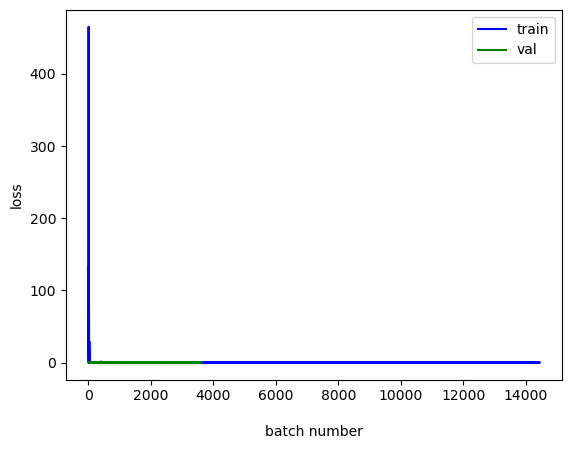

In [27]:
sns.lineplot(
    x = np.arange(1, len(results['loss_train'])+1),
    y = results['loss_train'],
    color = 'blue',
    label = 'train'
)
sns.lineplot(
    x = np.arange(1, len(results['loss_val'])+1),
    y = results['loss_val'],
    color = 'green',
    label = 'val'
)

plt.xlabel('\nbatch number')
plt.ylabel('loss')
plt.legend()

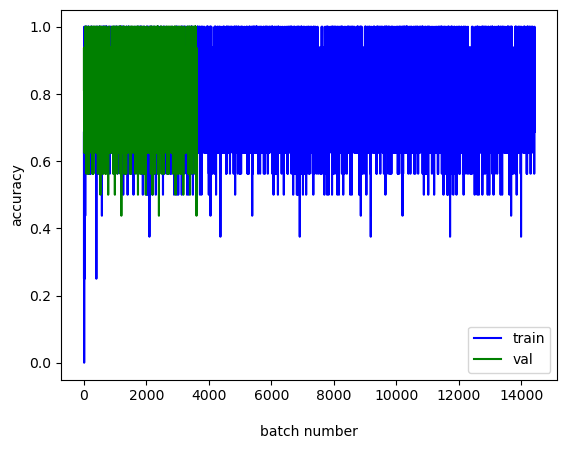

In [28]:
sns.lineplot(
    x = np.arange(1, len(results['train_accuracy'])+1),
    y = results['train_accuracy'],
    color = 'blue',
    label = 'train'
)
sns.lineplot(
    x = np.arange(1, len(results['val_accuracy'])+1),
    y = results['val_accuracy'],
    color = 'green',
    label = 'val'
)
plt.xlabel('\nbatch number')
plt.ylabel('accuracy')
plt.legend()

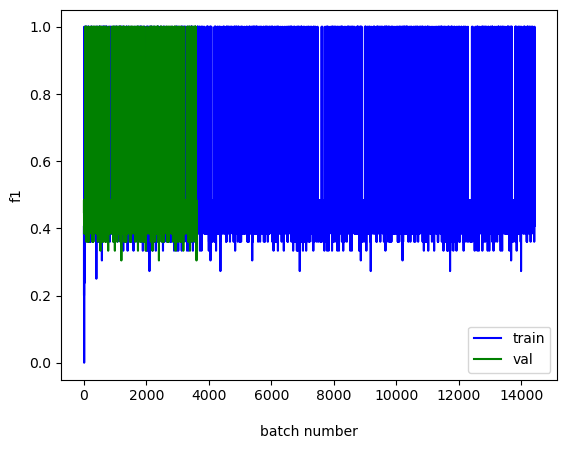

In [29]:
sns.lineplot(
    x = np.arange(1, len(results['train_f1'])+1),
    y = results['train_f1'],
    color = 'blue',
    label = 'train'
)
sns.lineplot(
    x = np.arange(1, len(results['val_f1'])+1),
    y = results['val_f1'],
    color = 'green',
    label = 'val'
)
plt.xlabel('\nbatch number')
plt.ylabel('f1')
plt.legend()

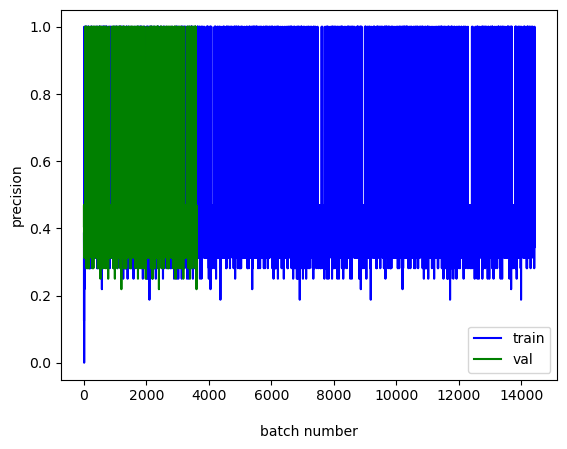

In [30]:
sns.lineplot(
    x = np.arange(1, len(results['train_precision'])+1),
    y = results['train_precision'],
    color = 'blue',
    label = 'train'
)
sns.lineplot(
    x = np.arange(1, len(results['val_precision'])+1),
    y = results['val_precision'],
    color = 'green',
    label = 'val'
)
plt.xlabel('\nbatch number')
plt.ylabel('precision')
plt.legend()

In [31]:
test_dataloader = DataLoader(
    dataset = Kinopoisk_Dataset('test'),
    batch_size = 8
)


test_data_results = {
           'accuracy' : [],
           'f1': [],
           'precision': [],
           'recall': []
            }


model.eval()
with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)[0]
        batch_metrics_slovar_test = compute_metrics(outputs, labels)

        test_data_results['accuracy'].append(batch_metrics_slovar_test['Accuracy'])
        test_data_results['f1'].append(batch_metrics_slovar_test['F1'])
        test_data_results['precision'].append(batch_metrics_slovar_test['Precision'])
        test_data_results['recall'].append(batch_metrics_slovar_test['Recall'])

In [32]:
for metric in list(test_data_results.keys()):
    print('{}: {:.3f}'.format(metric, np.mean(test_data_results[metric])))

accuracy: 0.814
f1: 0.541
precision: 0.503
recall: 0.595


# RuBERT model

In [38]:
test = pd.read_csv('test.csv')
test.head()

,text,label,link,input_ids,attention_mask
0,13 сентября в российский прокат выходит комеди...,1,dataset/pos/479608-21.txt,"[101, 441, 1141, 179, 3662, 875, 5273, 9213, 7...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,"Признаюсь, я заинтересовался этим фильмом дале...",1,dataset/pos/843789-18.txt,"[101, 1068, 5079, 515, 746, 113, 208, 437, 771...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,"Взглянув на описание сериала, я ждал нечто 'Се...",1,dataset/pos/394375-68.txt,"[101, 147, 708, 560, 9810, 7972, 414, 10974, 6...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,С самого начала возникает вопрос:' Что происхо...,1,dataset/pos/16751-1.txt,"[101, 162, 3238, 1889, 490, 8097, 6606, 6782, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,Редко когда такой крупнобюджетный блокбастер п...,0,dataset/neg/505966-40.txt,"[101, 6756, 717, 1163, 4864, 187, 1073, 12273,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [40]:
from transformers import pipeline

pipe = pipeline("text-classification", model="blanchefort/rubert-base-cased-sentiment-mokoron")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [50]:
max_length = 512
test['text'] = test['text'].apply(lambda x: x[:max_length])
result_RuBERT = pipe(test['text'].to_list())

In [57]:
data_RuBERT = {
    'label': [],
    'score': []
}

for slovar in result_RuBERT:
    label_RuBERT = slovar['label']
    if '0' in label_RuBERT:
        data_RuBERT['label'].append(0)
    else:
        data_RuBERT['label'].append(1)
    data_RuBERT['score'].append(slovar['score'])

data_RuBERT = pd.DataFrame(data_RuBERT)
data_RuBERT = data_RuBERT.rename({'label': 'label_predict_RuBERT'}, axis = 1)
data_RuBERT['lable_true'] = test['label']
data_RuBERT.head()

,label_predict_RuBERT,score,lable_true
0,0,0.537396,1
1,1,0.999896,1
2,0,0.529620,1
3,1,0.999891,1
4,0,0.524167,0


In [58]:
Precision, Recall, f1, _ = precision_recall_fscore_support(
        data_RuBERT['lable_true'].to_list(),
        data_RuBERT['label_predict_RuBERT'].to_list(),
        average = 'macro'
    )

f1

0.4085485266657558

# Rubert model fine-tuning

In [6]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("blanchefort/rubert-base-cased-sentiment-mokoron")
model = AutoModelForSequenceClassification.from_pretrained("blanchefort/rubert-base-cased-sentiment-mokoron")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Нужно ли тренировать токенизатор в этом случае !

In [ ]:
train_dataloader = DataLoader(
    dataset = Kinopoisk_Dataset('train'),
    batch_size = 16,
    drop_last = True
)

val_dataloader = DataLoader(
    dataset = Kinopoisk_Dataset('val'),
    batch_size = 16,
    drop_last = True
)


optimizer = torch.optim.Adam(model.parameters(), lr = 0.05)
loss_fn = nn.CrossEntropyLoss()

model, results =\
training_loop(
        # папка сохранения
        name_model_folder = 'model_3',
        # основные настройки
        epoches = 3,
        model = model,
        optimizer = optimizer,
        loss_fn = loss_fn,
        train_dataloader = train_dataloader,
        val_dataloader = val_dataloader,
        # regulizer
        regulizer_append = False,
        reg_type = None,
        # verbose
        verbose_epoch = 1
        )

In [ ]:
test_dataloader = DataLoader(
    dataset = Kinopoisk_Dataset('test'),
    batch_size = 8
)


test_data_results_RuBERT = {
           'accuracy' : [],
           'f1': [],
           'precision': [],
           'recall': []
            }


model.eval()
with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)[0]
        batch_metrics_slovar_test = compute_metrics(outputs, labels)

        test_data_results_RuBERT['accuracy'].append(batch_metrics_slovar_test['Accuracy'])
        test_data_results_RuBERT['f1'].append(batch_metrics_slovar_test['F1'])
        test_data_results_RuBERT['precision'].append(batch_metrics_slovar_test['Precision'])
        test_data_results_RuBERT['recall'].append(batch_metrics_slovar_test['Recall'])

# Вывод

- distill-bert-ucased fine-tuning 

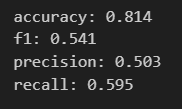


- RuBERT без тренировки ( f1 = 0.4085485266657558)


